<a href="https://colab.research.google.com/github/alimehdy/ai-projects/blob/main/advanced_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Advanced RAG project based on [huggingface tutorial](https://huggingface.co/learn/cookbook/en/advanced_rag)**


# **Step 1: Install dependencies**

In [1]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

# **Step 2: Import datasets**

In [4]:
import datasets
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [21]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]
nbr_of_docs = len(RAW_KNOWLEDGE_BASE)
print(f"Number of documents: {nbr_of_docs}")

  0%|          | 0/2647 [00:00<?, ?it/s]

Number of documents: 2647


# **Step 3: Retriever & Embedding** *italicized text*

## **Step 3.1: Text splitting parameters**

In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

# chunk size must be less than the max allowed chunk size of the embedder we're going to use
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS
)

## **Step 3.2: Split documents**

In [33]:
docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
  docs_processed += text_splitter.split_documents([doc])

docs_processed[4] ## print an example

Document(metadata={'source': 'huggingface/evaluate/blob/main/docs/source/choosing_a_metric.mdx', 'start_index': 275}, page_content="## Categories of metrics\n\nThere are 3 high-level categories of metrics:\n\n1. *Generic metrics*, which can be applied to a variety of situations and datasets, such as precision and accuracy.\n2. *Task-specific metrics*, which are limited to a given task, such as Machine Translation (often evaluated using metrics [BLEU](https://huggingface.co/metrics/bleu) or [ROUGE](https://huggingface.co/metrics/rouge)) or Named Entity Recognition (often evaluated with [seqeval](https://huggingface.co/metrics/seqeval)).\n3. *Dataset-specific metrics*, which aim to measure model performance on specific benchmarks: for instance, the [GLUE benchmark](https://huggingface.co/datasets/glue) has a dedicated [evaluation metric](https://huggingface.co/metrics/glue).\n\nLet's look at each of these three cases:\n\n### Generic metrics\n\nMany of the metrics used in the Machine Lear

## **Step 3.3: Tokenization**

In [34]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


In [35]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]


  0%|          | 0/31085 [00:00<?, ?it/s]

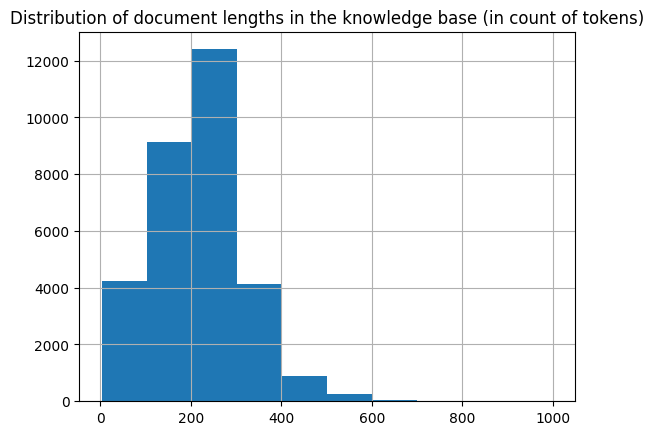

In [37]:
# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## **Step 3.4: Updating the text splitter**
Some of the documents exceeds the max number of tokens allowed by the embedder (512). We need to update the text

  0%|          | 0/16776 [00:00<?, ?it/s]

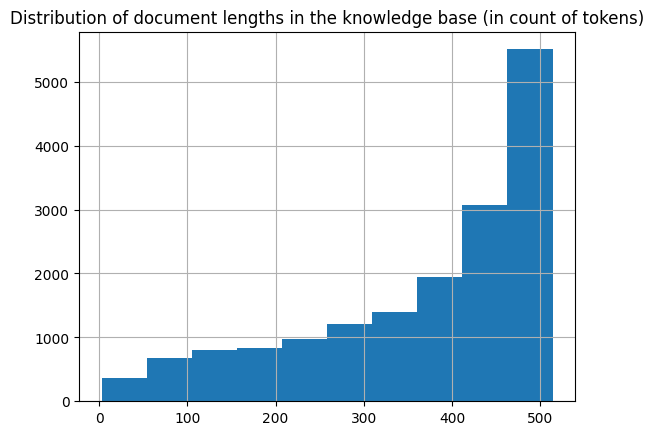

In [44]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## **Step 3.5: Embedding documents**

In [52]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceBgeEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [58]:
import time
start_time = time.time()
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed[:10], embedding_model, distance_strategy=DistanceStrategy.COSINE
)
end_time = time.time() - start_time
print(end_time)

6.681722164154053


In [67]:

import numpy as np

# Access the raw FAISS index
faiss_index = KNOWLEDGE_VECTOR_DATABASE.index

# Get all stored vectors
vectors = faiss_index.reconstruct_n(0, faiss_index.ntotal)

# Display the first few vectors
for i in range(min(5, faiss_index.ntotal)):
    print(f"Vector {i}: {vectors[i]}")

Vector 0: [-5.97100183e-02 -3.40230577e-02  2.06358209e-02 -3.20471413e-02
  3.41279767e-02  4.62457202e-02 -9.74881183e-03 -1.33902533e-03
 -6.61391160e-03  2.87235924e-03  4.68500927e-02 -7.26599842e-02
  3.97181101e-02 -2.31137057e-03  4.64059450e-02 -1.00139165e-02
 -2.92334892e-02 -1.27576208e-02 -5.05409725e-02  5.17030172e-02
  1.88912787e-02 -4.91888858e-02 -1.02722188e-02 -8.97061005e-02
  7.19360833e-04  4.79251817e-02 -2.10851375e-02 -4.12185956e-03
 -1.80993173e-02 -1.71243683e-01 -6.33331109e-03 -6.42493144e-02
 -6.11186202e-04 -1.26270140e-02 -4.67234524e-03 -3.33899297e-02
 -3.24782473e-03  4.93068881e-02 -3.32884379e-02  1.90330110e-02
  4.14961800e-02  1.72710174e-03 -3.15503143e-02 -6.85383752e-02
 -1.85940327e-04 -7.25762621e-02 -1.72760729e-02  1.43345715e-02
  5.79353375e-03 -7.56728463e-03  2.16153152e-02 -4.23050001e-02
  4.51516174e-03 -8.84283893e-03  7.91529100e-03  7.53205717e-02
  6.73046634e-02  3.32769603e-02 -5.21911820e-03  1.26314377e-02
  2.64443979e-0